<a id="goal"></a>
## Project Description and Goal

<font color="blue">
Analyzing the data on virtual telephony service “CallMeMaybe”, which Its clients are organizations. Finding clients with Non-Optimal plans and examine their impact on revenue.
clients with Non-Optimal plans are who:

  - Overpay for their current plans 
  - Need bigger plans, since they'll be more advantageous


## Step 1. Open the data file and study the general information

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import plotly.express as px
import plotly.graph_objects as go
import sys
import warnings
from scipy.stats import shapiro
from scipy import stats as st
from scipy.stats import mannwhitneyu
import numpy as np

In [3]:
data.head(5)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


In [5]:
data.isnull().sum()

user_id                   0
date                      0
direction                 0
internal                117
operator_id            8172
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64

In [6]:
clients.head(5)

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


In [7]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


## Conclusion

<font color="blue">
    
There are tow tables:
   - `telecom_dataset` with 52903 rows and 9 columns.
   - `telecom_clients` with 732 rows and 3 columns.<br>
    
There are missing values in the table `telecom_dataset` in columns: `internal` and `operator_id`.   
    

<a id="pre"></a>
## Step 2. Data preprocessing

 - **Processing missing values**

In [8]:
data.internal.isnull().sum()/len(data)

0.0021706059144373123

In [9]:
data.dropna(subset=['internal'],inplace=True)

In [10]:
data.operator_id.isnull().sum()/len(data)

0.15087849772241332

In [11]:
data['operator_id']=data.groupby('user_id')['operator_id'].apply(lambda x: x.fillna(x.median()))

In [12]:
data['operator_id']=data['operator_id'].fillna(0)

In [13]:
data.isnull().sum()

user_id                0
date                   0
direction              0
internal               0
operator_id            0
is_missed_call         0
calls_count            0
call_duration          0
total_call_duration    0
dtype: int64

<font color="blue">
    
Missing values maybe due to system malfunction. <br>
 - In column `internal` the number of them is low and just 0.2% of the data and we can delet them.  
 - In column `operator_id` missing values are 15% of the data. We can fill them with the help of the `user_id` column. (first we tried to fill them with the mode of the `operator_id` for each user, but it gave error because some users have no `operator_id`. Then we filled them with the median) and the rest could be filled with 0 because `operator_id` itself isn't important in the analysis and we just need the number of them for calculating the revenue. So, we can fill them with 0. (we can fill them all with 0 too)
    

 - **Data type replacement**

In [14]:
data.date=pd.to_datetime(data.date, dayfirst =True, format='%Y-%m-%d')

In [15]:
data.user_id =data.user_id.astype('object') 

In [16]:
clients.user_id =clients.user_id.astype('object') 

In [17]:
data.operator_id =data.operator_id.astype('object') 

In [18]:
clients.date_start=pd.to_datetime(clients.date_start,dayfirst =True, format='%Y-%m-%d')

In [19]:
data['date']=data['date'].dt.date

In [20]:
data.date=pd.to_datetime(data.date)

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53785 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              53785 non-null  object        
 1   date                 53785 non-null  datetime64[ns]
 2   direction            53785 non-null  object        
 3   internal             53785 non-null  object        
 4   operator_id          53785 non-null  object        
 5   is_missed_call       53785 non-null  bool          
 6   calls_count          53785 non-null  int64         
 7   call_duration        53785 non-null  int64         
 8   total_call_duration  53785 non-null  int64         
dtypes: bool(1), datetime64[ns](1), int64(3), object(4)
memory usage: 6.2+ MB


In [22]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      732 non-null    object        
 1   tariff_plan  732 non-null    object        
 2   date_start   732 non-null    datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 17.3+ KB


 - **Processing duplicates**

In [23]:
data.duplicated().sum()

4894

In [24]:
data.drop_duplicates(inplace=True)

In [25]:
clients.duplicated().sum()

0

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48891 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              48891 non-null  object        
 1   date                 48891 non-null  datetime64[ns]
 2   direction            48891 non-null  object        
 3   internal             48891 non-null  object        
 4   operator_id          48891 non-null  object        
 5   is_missed_call       48891 non-null  bool          
 6   calls_count          48891 non-null  int64         
 7   call_duration        48891 non-null  int64         
 8   total_call_duration  48891 non-null  int64         
dtypes: bool(1), datetime64[ns](1), int64(3), object(4)
memory usage: 3.4+ MB


In [27]:
Dictionary = {True: 'internal', False: 'external'}
data['internal']=data['internal'].map(Dictionary )

- **Check the users whether they are active**

We should make the analysis on active usesrs. So we check the date the statistics were retrieved and the registration date.

In [28]:
data= data.merge(clients, on='user_id')

In [29]:
data[data['date_start']>data['date']]

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start


In [30]:
len(data)

48891

- **Check the missed calls**

In [31]:
len(data.query('is_missed_call==True'))/len(data)

0.4376265570350371

In [32]:
data=data.query('is_missed_call==False and call_duration>0 and direction=="out"')

In [33]:
len(data)

15416

## Conclusion

<font color="blue">
  
**Missing values** <br>
column `internal` the number of them is low and just 0.2% of the data and we can delet them.  
column `operator_id` missing values are 15% of the data. we can fill them with 0 or fill them with the help of the `user_id` column.     
 
**Data types**<br>
We convert columns related to date into datetime format. We convert columns `user_id` and `operator_id` to object, because they aren't numbers. 
    
**Duplicates**<br> 
We checked the data for duplicates and dropped them.
    
We Checked the users whether they are active.<br>
We Checked the missed calls. They are 43% of the data! Assuming that there is no charge for the missed call, we can ignore them. <br>
Also we can ignore the calls with 0 duration and incomming calls because they are free and have no impact on revenue.

<a id="exp"></a>
## Step 3. Exploratory data analysis

- **number of clients**

In [34]:
data.user_id.nunique()

211

- **What time period the data contains**

In [35]:
data.date.min()

Timestamp('2019-08-02 00:00:00')

In [36]:
data.date.max()

Timestamp('2019-11-28 00:00:00')

In [37]:
data.describe()

,calls_count,call_duration,total_call_duration
count,15416.000000,15416.000000,15416.000000
mean,21.876687,2114.879152,2468.957512
std,64.163848,6374.987047,7444.415516
min,1.000000,1.000000,1.000000
25%,2.000000,152.000000,182.000000
50%,6.000000,618.000000,730.000000
75%,20.000000,2022.250000,2367.000000
max,1480.000000,144395.000000,166155.000000


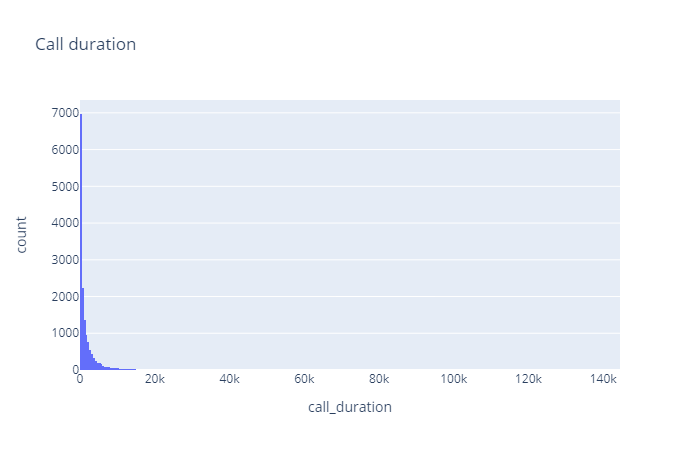

In [38]:
fig = px.histogram(data, x="call_duration", title='Call duration')
fig.show("png")

<font color="blue">
    
The distribution is very skewd influenced by outliers. Most of calls are under 500sec(8 min). There are call durations more than 40000 sec(11 hours).<br>
We have the call duration for calls of each operator on days.<br>
We don't know abaut the time-service of the clients. Assuming they provide 24-hour service, each operator can not have more than 86,400 seconds of call duration per day, it is irrational! And if the service is 8 to 10 hours as usual, more than 36,000 seconds is irrational. <br>
We assume the time-service is 10 hours a day. So, we can ignore the call duration more than 36000 sec.   

In [39]:
len(data.query('call_duration>36000'))

108

In [40]:
data=data.query('call_duration<=36000')

In [41]:
len(data)

15308

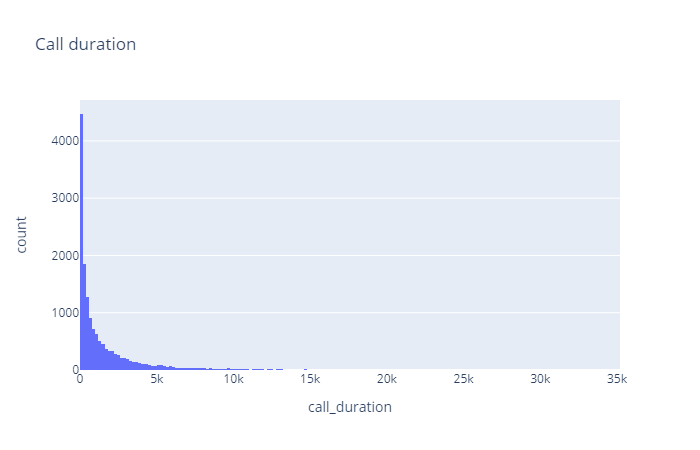

In [42]:
fig = px.histogram(data, x="call_duration", title='Call duration')
fig.show("png")

###  For each user, find:
  - **The number of calls made per month**
  - **The call duration per month**
  - **The number of operators**

In [43]:
data['month']=data['date'].dt.month

In [44]:
data.head(1)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start,month
3,166377,2019-08-05,out,internal,880020,False,1,10,18,B,2019-08-01,8


In [45]:
monthly_data=data.pivot_table(index=['user_id','month'], values=['call_duration'], columns='internal', aggfunc=['count','sum']).\
fillna(0).reset_index()

In [46]:
monthly_data.columns=['user_id','month','external_calls','internal_calls','external_duration','internal_duration']

In [47]:
monthly_data

,user_id,month,external_calls,internal_calls,external_duration,internal_duration
0,166377,8,37.0,1.0,64968.0,10.0
1,166377,9,59.0,0.0,85609.0,0.0
2,166377,10,54.0,1.0,81599.0,2.0
3,166377,11,44.0,1.0,78243.0,120.0
4,166405,8,31.0,0.0,44039.0,0.0
...,...,...,...,...,...,...
472,168481,11,4.0,0.0,280.0,0.0
473,168500,11,0.0,1.0,0.0,6.0
474,168601,11,19.0,0.0,24264.0,0.0
475,168603,11,4.0,0.0,905.0,0.0


In [48]:
monthly_data=monthly_data.merge(data.groupby(['user_id']).agg({'operator_id':'nunique'}), on='user_id').\
rename(columns={'operator_id':'operators'}).\
merge(clients, on='user_id').\
rename(columns={'tariff_plan':'plan'})

In [49]:
monthly_data.head(2)

,user_id,month,external_calls,internal_calls,external_duration,internal_duration,operators,plan,date_start
0,166377,8,37.0,1.0,64968.0,10.0,5,B,2019-08-01
1,166377,9,59.0,0.0,85609.0,0.0,5,B,2019-08-01


  - **Calculate the monthly revenue for each user** 

In [50]:
def cost(row):
    
    plan=row['plan']
    operators=row['operators']
    internal_duration=row['internal_duration']
    external_duration=row['external_duration']

    if plan=='A':
        
        basic_cost=5000
        operator_cost=operators*100
        
        if internal_duration <= 2000:
            internal_cost=0
        else:
            internal_cost= (internal_duration-2000)* 0.1
                
        external_cost= external_duration * 0.4
            
        
    elif plan=='B':
        
        basic_cost=2000
        operator_cost=operators*100
        
        if internal_duration <= 2000:
                internal_cost=0
        else:
            internal_cost= (internal_duration-2000) * 0.15
                
        external_cost= external_duration * 0.5
                
       
            
    elif plan=='C':   
        
        basic_cost=1000
        operator_cost=operators*100
        
        if internal_duration <= 2000:
                internal_cost=0
        else:
                internal_cost= (internal_duration-2000) * 0.3
                
        external_cost= external_duration * 0.7
 
    return basic_cost + operator_cost + internal_cost + external_cost

In [51]:
monthly_data['revenue']=monthly_data.apply(cost, axis=1)

In [52]:
monthly_data.head(2)

,user_id,month,external_calls,internal_calls,external_duration,internal_duration,operators,plan,date_start,revenue
0,166377,8,37.0,1.0,64968.0,10.0,5,B,2019-08-01,34984.0
1,166377,9,59.0,0.0,85609.0,0.0,5,B,2019-08-01,45304.5


###  Describe the customers' behavior

- **Plot a pie chart showing the shares of internal and external calls.**

In [53]:
df=data.groupby('internal').count().reset_index()[['internal','user_id']]

In [54]:
df

,internal,user_id
0,external,12759
1,internal,2549


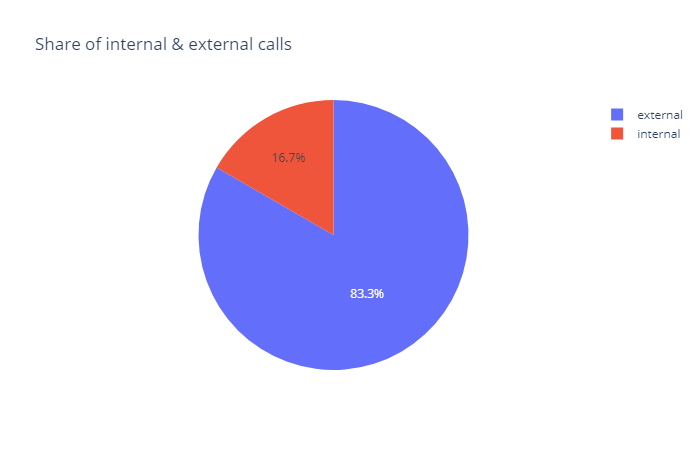

In [55]:
fig = px.pie(df, values='user_id', names='internal', title='Share of internal & external calls')
fig.show("png")

<font color="blue">
    
83% of the outgoing calls are external and 17% internal.     

 - **Plot distributions of the call duration for the clients of each plan per month.** 

In [56]:
monthly_data['total_duration']=monthly_data['internal_duration']+monthly_data['external_duration']

In [57]:
monthly_data.head(1)

,user_id,month,external_calls,internal_calls,external_duration,internal_duration,operators,plan,date_start,revenue,total_duration
0,166377,8,37.0,1.0,64968.0,10.0,5,B,2019-08-01,34984.0,64978.0


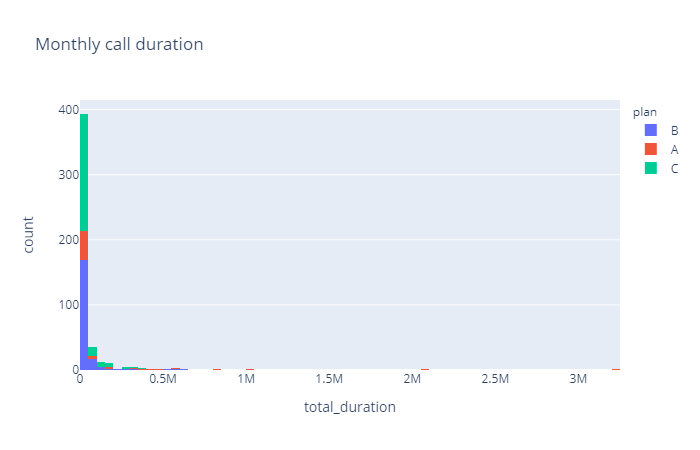

In [58]:
fig = px.histogram(monthly_data, x="total_duration", color='plan',title='Monthly call duration')
fig.show("png")

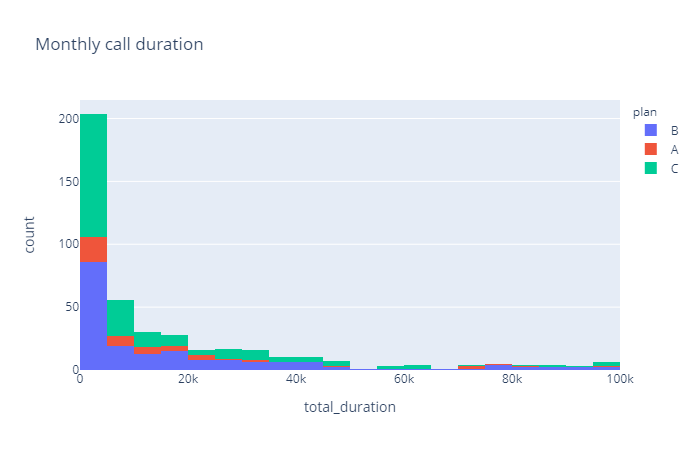

In [59]:
fig = px.histogram(monthly_data.query('total_duration<100000'), x="total_duration", color='plan',title='Monthly call duration')
fig.show("png")

<font color="blue">
    
The monthly call duration for many calls of plans B and C are less than 5k sec(1.3 hours). <br>
The monthly call duration for some calls of plans A and B are less than 5k sec(1.3 hours). They are the users who have low call duration and need smaller plans. <br> There are some huge call duration in plan A(more than 2M sec= 555 hours). 


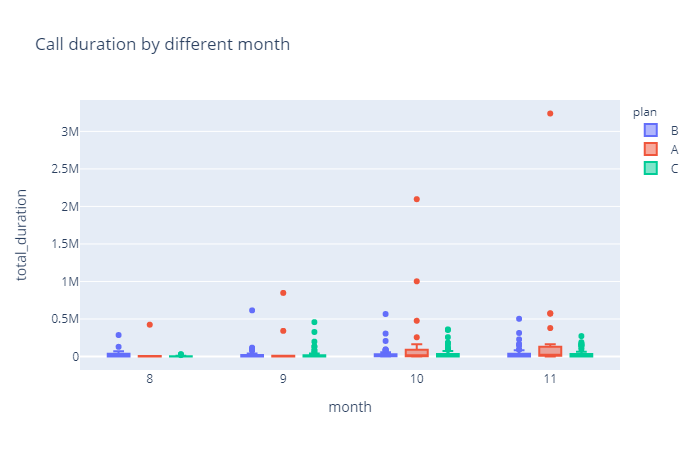

In [60]:
fig = px.box(monthly_data, x='month', y='total_duration',  color='plan', title='Call duration by different month')
fig.show("png")

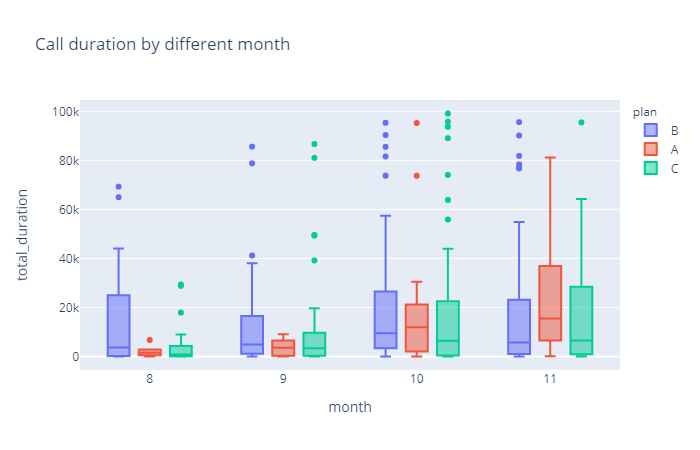

In [61]:
fig = px.box(monthly_data.query('total_duration<100000'), x='month', y='total_duration',  color='plan', title='Call duration by different month')
fig.show("png")

<font color="blue">
    
The call duration is increasing over the months(some clients have registered later). <br>The most call duration belongs to November.  <br>  
There are many outliers for plan B and C too. they are the users who have more call duration and need bigger plans. 

 - **Calculate the average of call duration for the clients of each plan.**

In [62]:
monthly_data.head(1)

,user_id,month,external_calls,internal_calls,external_duration,internal_duration,operators,plan,date_start,revenue,total_duration
0,166377,8,37.0,1.0,64968.0,10.0,5,B,2019-08-01,34984.0,64978.0


In [63]:
monthly_data.query('plan=="A"').total_duration.median()

12060.5

In [64]:
monthly_data.query('plan=="B"').total_duration.median()

8809.5

In [65]:
monthly_data.query('plan=="C"').total_duration.median()

6502.0

<font color="blue">
    
Since the distribution is skewed, median is a good choice to calculate the average call duration for the clients of each plan.
  - plan A: 12060 sec(3.3 hours)
  - plan B: 8809 sec(2.4 hours)
  - plan C: 6502 sec(1.8 hours)

 - **Plot histograms of revenue for each plan.**

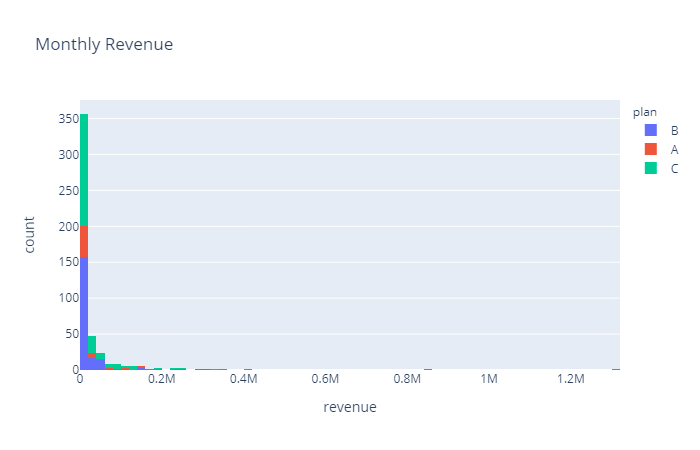

In [66]:
fig = px.histogram(monthly_data, x="revenue", color='plan',title='Monthly Revenue')
fig.show("png")

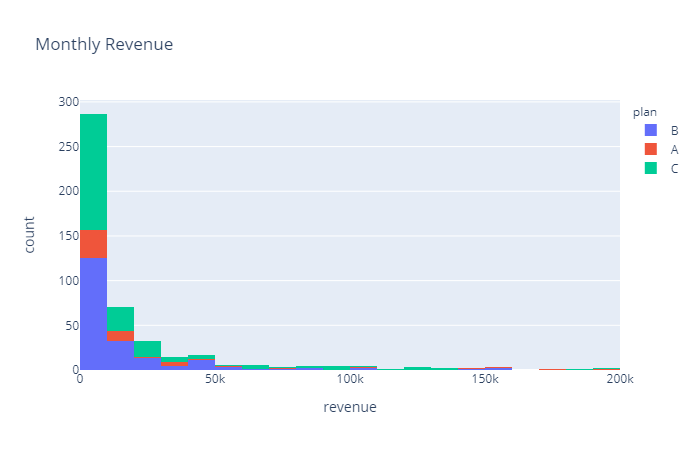

In [67]:
fig = px.histogram(monthly_data.query('revenue<200000'), x="revenue", color='plan',title='Monthly Revenue')
fig.show("png")

<font color="blue">
        
The monthly revenue for many clients of all plans are less than 20k. <br>
The monthly revenue for many clients of plans B and C are less than 10k. <br>
There is a huge revenue in plan A(more than 1.2M).  

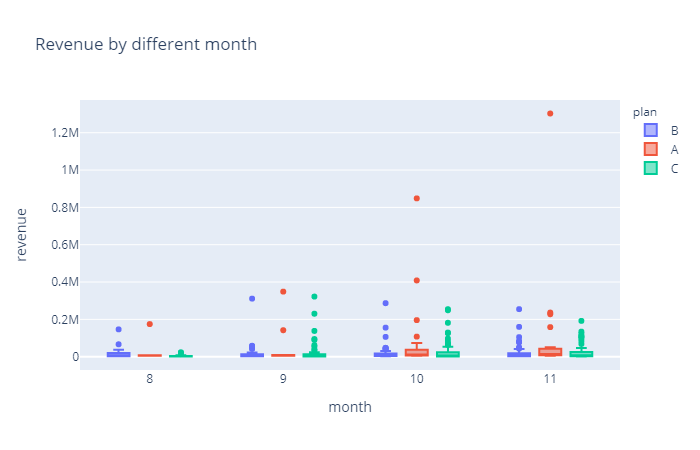

In [68]:
fig = px.box(monthly_data, x='month', y='revenue',  color='plan', title='Revenue by different month')
fig.show("png")

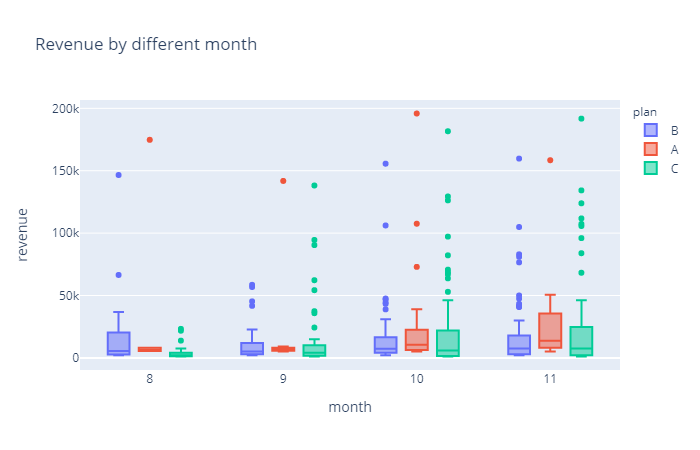

In [69]:
fig = px.box(monthly_data.query('revenue<200000'), x='month', y='revenue',  color='plan', title='Revenue by different month')
fig.show("png")

<font color="blue">
    
The revenue is increasing over the months. <br>
The most revenue belongs to November. <br>

 - **Calculate the average of revenue for the clients of each plan.**

In [70]:
monthly_data.query('plan=="A"').revenue.median()

9973.400000000001

In [71]:
monthly_data.query('plan=="B"').revenue.median()

6693.25

In [72]:
monthly_data.query('plan=="C"').revenue.median()

5824.099999999999

<font color="blue">
    
Since the distribution is skewed, median is a good choice to calculate the average revenue for the clients of each plan.
  - plan A: 9973 
  - plan B: 6693 
  - plan C: 5824 

### Find clients with non-optimal plans

clients who:

 - **Overpay for their current plans:** <br>Organizations that do not use much (don’t have many outgoing calls and long calls) but use big plans. The clients which use plan A or B, with low out call durations.

 - **Need bigger plans, since they'll be more advantageous:** <br>Organizations that use much but use little plans. The clients which use plan B or C, with high out call durations.

 - **number of users for each plan**

In [73]:
monthly_data.user_id.nunique()

211

In [74]:
monthly_data.query('plan=="A"').user_id.nunique()

27

In [75]:
monthly_data.query('plan=="B"').user_id.nunique()

84

In [76]:
monthly_data.query('plan=="C"').user_id.nunique()

100

 - **Split the customers into 2 categories: optimal and non-optimal.**

We can calculate the revenue for clients of each plan assuming they used other plans, and compare the revenues to check whether the plan is optimal or not.

 - **spliting the users of plan A**

In [77]:
df_A=monthly_data.query('plan=="A"')

In [78]:
df_A.plan="B"

In [79]:
df_A.head()

,user_id,month,external_calls,internal_calls,external_duration,internal_duration,operators,plan,date_start,revenue,total_duration
12,166407,8,1.0,0.0,20.0,0.0,8,B,2019-08-02,5808.0,20.0
13,166407,9,8.0,44.0,2067.0,4051.0,8,B,2019-08-02,6831.9,6118.0
14,166407,10,27.0,75.0,10441.0,7391.0,8,B,2019-08-02,10515.5,17832.0
15,166407,11,27.0,68.0,6530.0,5300.0,8,B,2019-08-02,8742.0,11830.0
44,166541,9,10.0,0.0,2608.0,0.0,2,B,2019-08-07,6243.2,2608.0


In [80]:
df_A['revenue2']=df_A.apply(cost, axis=1)

In [81]:
df_A.head()

,user_id,month,external_calls,internal_calls,external_duration,internal_duration,operators,plan,date_start,revenue,total_duration,revenue2
12,166407,8,1.0,0.0,20.0,0.0,8,B,2019-08-02,5808.0,20.0,2810.00
13,166407,9,8.0,44.0,2067.0,4051.0,8,B,2019-08-02,6831.9,6118.0,4141.15
14,166407,10,27.0,75.0,10441.0,7391.0,8,B,2019-08-02,10515.5,17832.0,8829.15
15,166407,11,27.0,68.0,6530.0,5300.0,8,B,2019-08-02,8742.0,11830.0,6560.00
44,166541,9,10.0,0.0,2608.0,0.0,2,B,2019-08-07,6243.2,2608.0,3504.00


In [82]:
df_A.plan="C"

In [83]:
df_A['revenue3']=df_A.apply(cost, axis=1)

In [84]:
df_A=df_A[['user_id', 'revenue', 'revenue2', 'revenue3']].groupby('user_id').mean().reset_index()

In [85]:
def optimal(row):
    revenue=row['revenue']
    revenue2=row['revenue2']
    revenue3=row['revenue3']
    
    if revenue2<revenue:
        return "non_optimal"
    if revenue3<revenue:
        return "non_optimal"

    else: 
        return "optimal" 

In [86]:
df_A['optimal']=df_A.apply(optimal , axis=1)

In [87]:
df_A.query('optimal=="non_optimal"').head()

,user_id,revenue,revenue2,revenue3,optimal
0,166407,7974.350000,5585.075000,5940.800000,non_optimal
1,166541,6885.066667,4306.333333,4148.866667,non_optimal
3,166609,6854.800000,4193.500000,3870.900000,non_optimal
4,166713,5129.600000,2137.000000,1151.800000,non_optimal
5,166725,10894.200000,9342.750000,11239.850000,non_optimal


In [88]:
len(df_A.query('optimal=="non_optimal"'))

15

In [89]:
len(df_A.query('optimal=="non_optimal"'))/len(df_A)

0.5555555555555556

- **spliting the users of plan B**

In [90]:
df_B=monthly_data.query('plan=="B"')

In [91]:
df_B.plan="A"

In [92]:
df_B['revenue2']=df_B.apply(cost, axis=1)

In [93]:
df_B.plan="C"

In [94]:
df_B['revenue3']=df_B.apply(cost, axis=1)

In [95]:
df_B=df_B[['user_id', 'revenue', 'revenue2', 'revenue3']].groupby('user_id').mean().reset_index()

In [96]:
df_B['optimal']=df_B.apply(optimal , axis=1)

In [97]:
df_B.query('optimal=="non_optimal"').head()

,user_id,revenue,revenue2,revenue3,optimal
0,166377,41302.375,36541.9,55823.325,non_optimal
1,166405,99299.125,83039.3,136818.775,non_optimal
2,166406,41277.500,36482.0,55868.500,non_optimal
3,166485,47029.075,40999.2,64448.975,non_optimal
4,166495,21324.375,20499.5,27974.125,non_optimal


In [98]:
len(df_B.query('optimal=="non_optimal"'))

57

In [99]:
len(df_B.query('optimal=="non_optimal"'))/len(df_B)

0.6785714285714286

- **spliting the users of plan C**

In [100]:
df_C=monthly_data.query('plan=="C"')

In [101]:
df_C.plan="A"

In [102]:
df_C['revenue2']=df_C.apply(cost, axis=1)

In [103]:
df_C.plan="B"

In [104]:
df_C['revenue3']=df_C.apply(cost, axis=1)

In [105]:
df_C=df_C[['user_id', 'revenue', 'revenue2', 'revenue3']].groupby('user_id').mean().reset_index()

In [106]:
df_C['optimal']=df_C.apply(optimal , axis=1)

In [107]:
df_C.query('optimal=="non_optimal"').head()

,user_id,revenue,revenue2,revenue3,optimal
0,166487,4945.100000,7297.200000,4846.500000,non_optimal
2,166511,85853.875000,53616.500000,62695.625000,non_optimal
3,166520,44755.825000,30731.900000,33739.875000,non_optimal
8,166677,5105.633333,7388.933333,4961.166667,non_optimal
10,166691,8316.300000,9223.600000,7254.500000,non_optimal


In [108]:
len(df_C.query('optimal=="non_optimal"'))

53

In [109]:
len(df_C.query('optimal=="non_optimal"'))/len(df_C)

0.53

In [110]:
len(monthly_data)

477

In [111]:
df_A_opt=df_A[['user_id','optimal']]
df_B_opt=df_B[['user_id','optimal']]
df_C_opt=df_C[['user_id','optimal']]

In [112]:
df=df_A_opt.append(df_B_opt).append(df_C_opt)

In [113]:
monthly_data=monthly_data.merge(df, on='user_id')

In [114]:
monthly_data.head()

,user_id,month,external_calls,internal_calls,external_duration,internal_duration,operators,plan,date_start,revenue,total_duration,optimal
0,166377,8,37.0,1.0,64968.0,10.0,5,B,2019-08-01,34984.0,64978.0,non_optimal
1,166377,9,59.0,0.0,85609.0,0.0,5,B,2019-08-01,45304.5,85609.0,non_optimal
2,166377,10,54.0,1.0,81599.0,2.0,5,B,2019-08-01,43299.5,81601.0,non_optimal
3,166377,11,44.0,1.0,78243.0,120.0,5,B,2019-08-01,41621.5,78363.0,non_optimal
4,166405,8,31.0,0.0,44039.0,0.0,10,B,2019-08-02,25019.5,44039.0,non_optimal


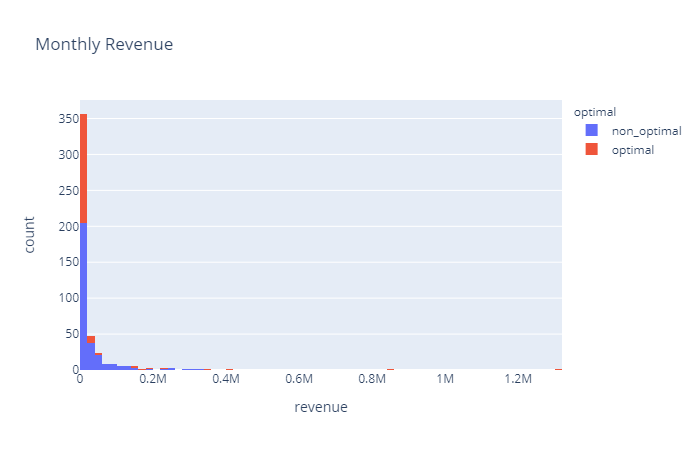

In [115]:
fig = px.histogram(monthly_data, x="revenue", color='optimal',title='Monthly Revenue')
fig.show("png")

## Conclusion

<font color="blue">
   
We checked the data for irrational data and dropped them.<br>
Also we ignored the calls with 0 duration and incomming calls because they are free and have no impact on revenue.<br>
    
83% of the outgoing calls are external and 17% internal.<br>
    
For each user, We found the number of calls, the call duration and calculate the revenue per month.<br>
    
**call duration**<br>
The monthly call duration for many calls of all plans are less than 50k sec(13 hours). <br>
There are some huge call duration in plan A(more than 2M sec= 555 hours).<br>
There are many outliers for plan B and C too. They are the users who have more call duration and need bigger plans.

**revenue**    
The monthly revenue for many clients of all plans are less than 20k. <br>
There is a huge revenue in plan A(more than 1.2M).

**the average call duration and revenue for each plan**
  - plan A: 12060 sec(3.3 hours) / 9973
  - plan B: 8809 sec(2.4 hours) / 6693
  - plan C: 6502 sec(1.8 hours) / 5824

**non-optimal customers**  
There are 211 customers. <br>
The number of customers for each plan are A:27  B: 84  C:100  <br>
We split the customers into 2 categories: optimal and non-optimal.<br> The share of non-optimal users for each plan are
   - A: 15(55%)
   - B: 57(67%)
   - C: 53(53%)



<a id="test"></a>
## Step 4. Test the hypotheses

 - **The average revenue from clients of the optimal and non-optimal categories differs.**

H0: The average revenue from clients of the optimal and non-optimal categories is equal.   
H1: The average revenue from clients of the optimal and non-optimal categories differs.

In [116]:
monthly_data.head(1)

,user_id,month,external_calls,internal_calls,external_duration,internal_duration,operators,plan,date_start,revenue,total_duration,optimal
0,166377,8,37.0,1.0,64968.0,10.0,5,B,2019-08-01,34984.0,64978.0,non_optimal


In [117]:
sample1=monthly_data.query('optimal=="optimal"').revenue
sample2=monthly_data.query('optimal=="non_optimal"').revenue

In [118]:
alpha = 0.05

In [119]:
stat, p = shapiro(sample1)

if p > alpha:
    print('Sample looks Normal (fail to reject H0)')
else:
    print('Sample does not look Normal (reject H0)')

Sample does not look Normal (reject H0)


In [120]:
stat, p = shapiro(sample2)

if p > alpha:
    print('Sample looks Normal (fail to reject H0)')
else:
    print('Sample does not look Normal (reject H0)')

Sample does not look Normal (reject H0)


<font color="blue">
    
Since the distributions are skewd and not normal, we use the mannwhitneyu method to test the hypotheses.

In [121]:
stat, p = mannwhitneyu(sample1, sample2)
print(p)

if (p<alpha):
        print("We reject the null hypothesis")
else:
        print("We can't reject the null hypothesis") 

2.3249218873578713e-11
We reject the null hypothesis


<font color="blue">
    
H0 would be rejected. The average revenue from clients of the optimal and non-optimal categories differs.

 - **The average revenue from clients of A and B calling plans differs.**

H0: The average revenue from clients of A and B calling plans is equal.   
H1: The average revenue from clients of A and B calling plans differs.

In [122]:
sample1=monthly_data.query('plan=="A"').revenue
sample2=monthly_data.query('plan=="B"').revenue

In [123]:
stat, p = shapiro(sample1)

if p > alpha:
    print('Sample looks Normal (fail to reject H0)')
else:
    print('Sample does not look Normal (reject H0)')

Sample does not look Normal (reject H0)


In [124]:
stat, p = shapiro(sample2)

if p > alpha:
    print('Sample looks Normal (fail to reject H0)')
else:
    print('Sample does not look Normal (reject H0)')

Sample does not look Normal (reject H0)


In [125]:
stat, p = mannwhitneyu(sample1, sample2)
print(p)

if (p<alpha):
        print("We reject the null hypothesis")
else:
        print("We can't reject the null hypothesis") 

1.0428607057750376e-05
We reject the null hypothesis


<font color="blue">
    
H0 would be rejected. The average revenue from clients of A and B calling plans differs.

 - **The average revenue from clients of A and C calling plans differs.**

H0: The average revenue from clients of A and C calling plans is equal.   
H1: The average revenue from clients of A and C calling plans differs.

In [126]:
sample1=monthly_data.query('plan=="A"').revenue
sample2=monthly_data.query('plan=="C"').revenue

In [127]:
stat, p = shapiro(sample1)

if p > alpha:
    print('Sample looks Normal (fail to reject H0)')
else:
    print('Sample does not look Normal (reject H0)')

Sample does not look Normal (reject H0)


In [128]:
stat, p = shapiro(sample2)

if p > alpha:
    print('Sample looks Normal (fail to reject H0)')
else:
    print('Sample does not look Normal (reject H0)')

Sample does not look Normal (reject H0)


In [129]:
stat, p = mannwhitneyu(sample1, sample2)
print(p)

if (p<alpha):
        print("We reject the null hypothesis")
else:
        print("We can't reject the null hypothesis") 

4.870341973702907e-06
We reject the null hypothesis


<font color="blue">
    
H0 would be rejected. The average revenue from clients of A and C calling plans differs.

 - **The average revenue from clients of B and C calling plans differs.**

H0: The average revenue from clients of B and C calling plans is equal.   
H1: The average revenue from clients of B and C calling plans differs.

In [130]:
sample1=monthly_data.query('plan=="B"').revenue
sample2=monthly_data.query('plan=="C"').revenue

In [131]:
stat, p = shapiro(sample1)

if p > alpha:
    print('Sample looks Normal (fail to reject H0)')
else:
    print('Sample does not look Normal (reject H0)')

Sample does not look Normal (reject H0)


In [132]:
stat, p = shapiro(sample2)

if p > alpha:
    print('Sample looks Normal (fail to reject H0)')
else:
    print('Sample does not look Normal (reject H0)')

Sample does not look Normal (reject H0)


In [133]:
stat, p = mannwhitneyu(sample1, sample2)
print(p)

if (p<alpha):
        print("We reject the null hypothesis")
else:
        print("We can't reject the null hypothesis") 

0.012628100388730324
We reject the null hypothesis


<font color="blue">
    
H0 would be rejected. The average revenue from clients of B and C calling plans differs.

## Conclusion

<font color="blue">
    
We tested 4 hypotheses:
 - H0: The average revenue from clients of the optimal and non-optimal categories is equal.   
 - H1: The average revenue from clients of the optimal and non-optimal categories differs.
   <br> 
    
 - H0: The average revenue from clients of A and B calling plans is equal.   
 - H1: The average revenue from clients of A and B calling plans differs. 
    
    <br>
 - H0: The average revenue from clients of A and C calling plans is equal.   
 - H1: The average revenue from clients of A and C calling plans differs.
    
    <br>
 - H0: The average revenue from clients of B and C calling plans is equal.   
 - H1: The average revenue from clients of B and C calling plans differs.
    
In all of the hypotheses the H0 was rejected.  <br>
The average revenue from clients of all three plans and also of optimal and non_optimal categories differs.

## Step 5. Final Conclusion 

<font color="blue">

### [Goal](#goal)
Analyzing the data on virtual telephony service “CallMeMaybe”, which Its clients are organizations. Finding clients with Non-Optimal plans and examine their impact on revenue.
    
### [Data preprocessing](#pre)
We checked the missing values, data types and duplicates in the data.<br>
We Checked the users whether they are active.<br>
We dropped the missed calls and calls with 0 duration. <br>
We Checked irrational call durations and dropped them. <br>
Also we ignored the incoming calls because they are free and have no impact on revenue.
    
### [Exploratory data analysis](#exp)
83% of the outgoing calls are external and 17% internal.<br>
    
For each user, We found the number of calls, the call duration and calculate the revenue per month.<br>
    
**call duration**<br>
The monthly call duration for many calls of all plans are less than 50k sec(13 hours). <br>
There are some huge call duration in plan A(more than 2M sec= 555 hours).<br>
There are many outliers for plan B and C too. They are the users who have more call duration and need bigger plans.

**revenue**    
The monthly revenue for many clients of all plans are less than 20k. <br>
There is a huge revenue in plan A(more than 1.2M).

**the average call duration and revenue for each plan**
  - plan A: 12060 sec(3.3 hours) / 9973
  - plan B: 8809 sec(2.4 hours) / 6693
  - plan C: 6502 sec(1.8 hours) / 5824

**non-optimal customers**  
There are 211 customers. <br>
The number of customers for each plan are A:27  B: 84  C:100  <br>
We split the customers into 2 categories: optimal and non-optimal.<br> The share of non-optimal users for each plan are
   - A: 15(55%)
   - B: 57(67%)
   - C: 53(53%)  
    
### [Test the hypotheses](#test)     
We tested 4 hypotheses:
 - The average revenue from clients of the optimal and non-optimal categories differs.
    
 - The average revenue from clients of A and B calling plans differs. 
   
 - The average revenue from clients of A and C calling plans differs.

 - The average revenue from clients of B and C calling plans differs.
    
In all of the hypotheses the H0 was rejected.  <br>
The average revenue from clients of all three plans and also of optimal and non_optimal categories differs.  
    
### Final conclusion and suggestions
We found non-optimal customers in all three plans. And we checked that the revenue for them is different from the optimal customers. The marketing department can be advised to recommend more cost-effective plans for non-optimal customers. In this way we can gain more trust and loyalty of customers.    
    

## Documentation

[statistical-hypothesis(shapiro & mannwhitneyu)](https://machinelearningmastery.com/statistical-hypothesis-tests-in-python-cheat-sheet/)

[plotly-Piechart](https://plotly.com/python/pie-charts/)

[plotly-Histogram](https://plotly.com/python/histograms/)

## Additional links

The link of [Telecom Dashboard][]

[Telecom Dashboard]: https://public.tableau.com/app/profile/fateme6870/viz/TelecomDashboard_16252123551260/TelecomDashboard